Import Necessary Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
import json
from pandas import json_normalize
from datetime import datetime
from matplotlib.patches import Circle

In [2]:
df = pd.read_csv('flattened_telemetry.csv', sep=',', low_memory=False)
df

,_id,ulCarrierFreq,timestamp,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,...,ulMcs,rssi,cqi,pucchSnr,puschSnr,rnti,dlBytes,phr,pmi_0,pmi_1
0,67c20d2e037f557dd6e2cd3f,3.750240e+09,2025-02-28 19:23:26.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67c20d2f037f557dd6e2cd40,3.750240e+09,2025-02-28 19:23:27.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67c20d30037f557dd6e2cd41,3.750240e+09,2025-02-28 19:23:28.263000064,12345678.0,213.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67c20d31037f557dd6e2cd42,3.750240e+09,2025-02-28 19:23:29.263000064,12345678.0,313.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67c20d32037f557dd6e2cd43,3.750240e+09,2025-02-28 19:23:30.263000064,12345678.0,413.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176428,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,21.5,f0e1,10641.0,61.0,15.0,1.0
176429,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,69.0,6.0,...,6.0,96.0,15.0,15.0,31.0,93aa,24353.0,59.0,0.0,1.0
176430,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,62.0,6.0,...,6.0,62.0,15.0,5.0,3.0,b078,19416.0,52.0,2.0,1.0
176431,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,27.0,f0e1,10786.0,61.0,15.0,1.0


Training DATA Analysis

In [3]:
df.shape # size of the training data (#rows, #features)

(176433, 29)

In [4]:
df.dropna(inplace = True) # dropping NaN Values i.e removing all empty noisy data
df.shape # size after removing NaN values

(168861, 29)

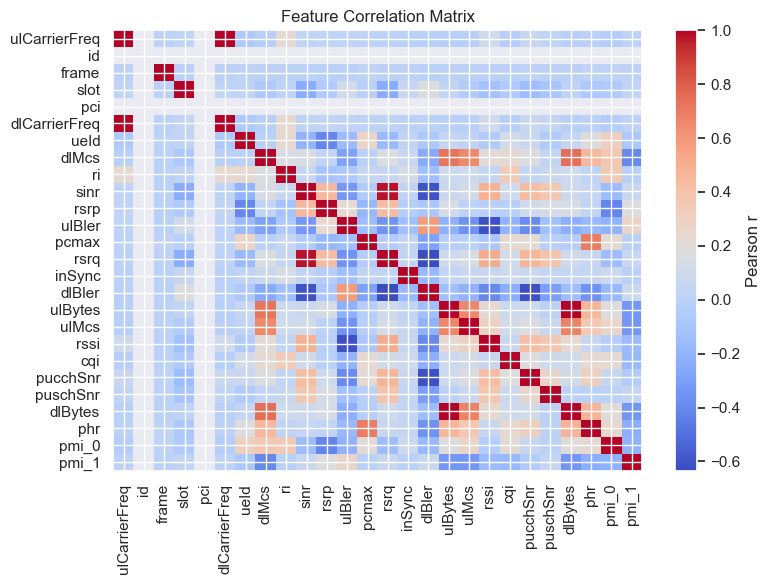

In [5]:
#Analysing the correlation between features (Only Numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols] .corr()
scaler = StandardScaler()
df1 = pd.DataFrame()
df1[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Removing 2% of outliers/Noisy data using Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df['iforest_label'] = iso.fit_predict(df[numeric_cols])
# label = −1 is an outlier
n_iso = (df['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df):.2%})")

IsolationForest outliers: 1689 (1.00%)


In [7]:
df = df[df['iforest_label'] == 1].reset_index(drop=True) #keeping only inliners
df.drop(columns=['iforest_label'], inplace=True)

In [8]:
df.describe()

,ulCarrierFreq,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,ri,sinr,...,ulBytes,ulMcs,rssi,cqi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1
count,1.671720e+05,167172.0,167172.000000,167172.000000,167172.0,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,...,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,167172.000000,1.671720e+05,167172.000000,167172.000000,167172.000000
mean,3.750306e+09,12345678.0,509.845471,10.709515,0.0,3.750306e+09,22.580516,10.139832,1.932644,21.165294,...,1.467366e+09,7.372090,77.384429,14.520045,14.363141,15.321190,6.683665e+08,53.555775,8.591182,0.597768
std,1.404990e+06,0.0,295.017824,6.528031,0.0,1.404990e+06,10.364159,7.632047,0.268342,7.940488,...,4.395379e+09,2.707526,6.998459,1.805117,5.032339,7.566763,1.814033e+09,7.887585,5.979025,0.545379
min,3.750240e+09,12345678.0,0.000000,2.000000,0.0,3.750240e+09,1.000000,0.000000,1.000000,-10.000000,...,0.000000e+00,0.000000,59.800000,1.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3.750240e+09,12345678.0,254.000000,4.000000,0.0,3.750240e+09,20.000000,6.000000,2.000000,23.500000,...,1.259912e+06,6.000000,75.000000,15.000000,13.000000,12.000000,4.649668e+05,52.000000,0.000000,0.000000
50%,3.750240e+09,12345678.0,507.000000,9.000000,0.0,3.750240e+09,22.000000,9.000000,2.000000,23.500000,...,8.041060e+06,6.000000,79.900000,15.000000,15.000000,16.000000,2.219774e+06,52.000000,11.000000,1.000000
75%,3.750240e+09,12345678.0,766.000000,19.000000,0.0,3.750240e+09,24.000000,9.000000,2.000000,23.500000,...,3.637968e+07,8.000000,81.500000,15.000000,16.000000,18.000000,1.211683e+08,52.000000,13.000000,1.000000
max,3.780300e+09,12345678.0,1023.000000,19.000000,0.0,3.780300e+09,69.000000,27.000000,4.000000,23.500000,...,2.275132e+10,27.000000,120.000000,15.000000,60.000000,63.500000,9.106684e+09,65.000000,15.000000,3.000000


In [9]:
#features in the data
df.columns

Index(['_id', 'ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', 'ueId', 'dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler',
       'pcmax', 'rsrq', 'inSync', 'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'cqi',
       'pucchSnr', 'puschSnr', 'rnti', 'dlBytes', 'phr', 'pmi_0', 'pmi_1'],
      dtype='object')

Considering the following features for user signature:
'rnti'
'rsrp'
'pucchSnr'
'rssi'
'ulBler'
'puschSnr'
'dlBler'
'rsrq'
'sinr'


In [10]:
to_drop = [
    '_id', 'id', 'ueId',  'cqi',    # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df = df.drop(columns=to_drop, errors='ignore')

df.columns

Index(['sinr', 'rsrp', 'ulBler', 'rsrq', 'dlBler', 'rssi', 'pucchSnr',
       'puschSnr', 'rnti'],
      dtype='object')

In [11]:
df.head()

,sinr,rsrp,ulBler,rsrq,dlBler,rssi,pucchSnr,puschSnr,rnti
0,12.0,-89.0,0.169858,-11.0,0.065610,100.3,40.0,34.0,b39a
1,11.5,-89.0,0.275585,-11.0,0.059049,86.0,38.0,21.5,b39a
2,11.5,-89.0,0.444611,-11.0,0.047830,83.7,39.0,16.5,b39a
3,11.5,-89.0,0.397827,-11.0,0.038742,82.4,35.0,15.0,b39a
4,11.5,-89.0,0.396927,-11.0,0.031381,82.6,32.0,15.0,b39a


In [12]:
raw_cols = ['sinr','rsrp','rssi','pucchSnr','puschSnr','ulBler','dlBler','rsrq']
scaler_raw = StandardScaler() # Normalise
df_scaled = pd.DataFrame() # A new DataFrame to work on
df_scaled[raw_cols] = scaler_raw.fit_transform(df[raw_cols])


In [13]:
df_scaled['rnti']= df['rnti'] 

In [14]:
df_scaled.head()

,sinr,rsrp,rssi,pucchSnr,puschSnr,ulBler,dlBler,rsrq,rnti
0,-1.154252,-1.362237,3.274384,5.094437,2.468541,-0.466089,-0.236657,0.0823,b39a
1,-1.217220,-1.362237,1.231071,4.697006,0.816575,-0.221125,-0.256792,0.0823,b39a
2,-1.217220,-1.362237,0.902426,4.895722,0.155788,0.170499,-0.291221,0.0823,b39a
3,-1.217220,-1.362237,0.716670,4.100860,-0.042448,0.062103,-0.319111,0.0823,b39a
4,-1.217220,-1.362237,0.745248,3.504714,-0.042448,0.060018,-0.341701,0.0823,b39a


CREATING TIME WINDOWED SEQUENCES for each window: the mean of the features and their corresponding correalations are captured

In [15]:

def extract_phy_signatures(df_scaled,
                           raw_features=None,
                           window_size=50,
                           step_size=50,
                           label_col=None):
    """
    Slide a window over df and for each window compute:
      - mean of each raw_feature
      - Pearson correlation of every pair of raw_features

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed, timestamp-sorted DataFrame of physical-layer columns.
    raw_features : list of str, optional
        Columns to treat as the base attributes. If None, defaults to:
        ['sinr','rsrp','rssi','cqi','pucchSnr','puschSnr','ulBler','dlBler']
    window_size : int
        Number of rows per window.
    step_size : int
        Sliding step between windows (use ==window_size for non-overlap).
    label_col : str, optional
        Name of a column (e.g. 'rnti' or 'ueId') whose mode in each window
        will be returned as the true label for that signature.

    Returns
    -------
    sig_df : pd.DataFrame
        Each row is a signature: [mean_{f1} … mean_{fD}, corr_{f1,f2} …]
    labels : list, only if label_col is set
        The mode of `label_col` in each window, in the same order as sig_df.
    """
    if raw_features is None:
        raw_features = [
            'sinr', 'rsrp', 'rssi','rsrq',
            'pucchSnr', 'puschSnr', 'ulBler', 'dlBler'
        ]

    D = len(raw_features)
    # build column names
    corr_pairs = [(i, j) for i in range(D) for j in range(i+1, D)]
    col_names = ([f"mean_{f}" for f in raw_features] +
                [f"corr_{raw_features[i]}_{raw_features[j]}" 
                   for i,j in corr_pairs])

    signatures = []
    labels = []  # only used if label_col is provided

    for start in range(0, len(df_scaled) - window_size + 1, step_size):
        w = df_scaled.iloc[start:start+window_size]

        # 1) raw means
        means = w[raw_features].mean().values

        # 2) correlations
        cmat = w[raw_features].corr().values
        iu = np.triu_indices(D, k=1)
        corr_vals = cmat[iu]

        signatures.append(np.concatenate([means, corr_vals]))
        #signatures.append(means)
        # 3) window label (mode of label_col)
        if label_col is not None:
            labels.append(w[label_col].mode()[0])

    sig_df = pd.DataFrame(signatures, columns=col_names)
    if label_col is not None:
        return sig_df, labels
    return sig_df


# ----------------------------
# Example usage:



# 2) Get signatures *and* the per-window RNTI mode



In [16]:
sig_df, window_rntis = extract_phy_signatures(
    df_scaled,
    window_size=100,
    step_size=100,
    label_col='rnti'
)

In [17]:
sig_df.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp',
       'corr_sinr_rssi', 'corr_sinr_rsrq', 'corr_sinr_pucchSnr',
       'corr_sinr_puschSnr', 'corr_sinr_ulBler', 'corr_sinr_dlBler',
       'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler',
       'corr_rssi_rsrq', 'corr_rssi_pucchSnr', 'corr_rssi_puschSnr',
       'corr_rssi_ulBler', 'corr_rssi_dlBler', 'corr_rsrq_pucchSnr',
       'corr_rsrq_puschSnr', 'corr_rsrq_ulBler', 'corr_rsrq_dlBler',
       'corr_pucchSnr_puschSnr', 'corr_pucchSnr_ulBler',
       'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler', 'corr_puschSnr_dlBler',
       'corr_ulBler_dlBler'],
      dtype='object')

In [18]:
sig_df.describe()

,mean_sinr,mean_rsrp,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler,corr_sinr_rsrp,corr_sinr_rssi,...,corr_rsrq_pucchSnr,corr_rsrq_puschSnr,corr_rsrq_ulBler,corr_rsrq_dlBler,corr_pucchSnr_puschSnr,corr_pucchSnr_ulBler,corr_pucchSnr_dlBler,corr_puschSnr_ulBler,corr_puschSnr_dlBler,corr_ulBler_dlBler
count,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,481.000000,488.000000,...,504.000000,504.000000,429.000000,487.000000,1671.000000,1550.000000,1457.000000,1550.000000,1457.000000,1363.000000
mean,0.000514,0.001142,0.000225,0.000085,0.000418,0.000128,-0.000546,-0.000720,0.668635,0.331016,...,0.456203,0.264639,-0.383783,-0.615413,0.088763,-0.365235,-0.089989,-0.027561,-0.146283,0.149598
std,0.732608,0.621450,0.564616,0.701383,0.501820,0.368854,0.627489,0.780060,0.311994,0.450835,...,0.531967,0.400879,0.413016,0.460598,0.286206,0.442916,0.517006,0.308657,0.322341,0.476817
min,-2.787658,-2.027642,-2.066380,-2.520190,-2.053354,-1.651463,-0.859641,-0.438005,-0.948818,-0.643083,...,-0.738110,-0.700353,-0.977675,-1.000000,-0.754108,-0.999143,-1.000000,-0.991940,-0.991900,-0.710257
25%,0.285840,-0.130004,-0.088867,0.252242,-0.063219,-0.101918,-0.289806,-0.435624,0.392619,-0.068398,...,-0.009630,-0.065400,-0.773917,-0.998332,-0.092097,-0.775565,-0.352996,-0.124052,-0.233085,-0.257996
50%,0.294026,-0.061547,0.107391,0.279907,0.114631,0.044115,-0.137364,-0.410621,0.766238,0.187869,...,0.632143,0.077089,-0.408376,-0.957704,0.024062,-0.415784,0.021153,0.032450,-0.070198,-0.061913
75%,0.294026,0.229397,0.238206,0.279907,0.258699,0.187506,0.279310,-0.150359,0.978660,0.874609,...,0.938367,0.707824,-0.014900,-0.205043,0.173581,-0.007909,0.292469,0.173150,0.029547,0.699840
max,0.294026,3.019035,3.895665,0.279907,2.455497,1.735068,1.457306,2.571764,1.000000,0.928550,...,1.000000,0.962444,0.521948,0.751748,0.985756,0.830685,0.967380,0.824412,0.875030,1.000000


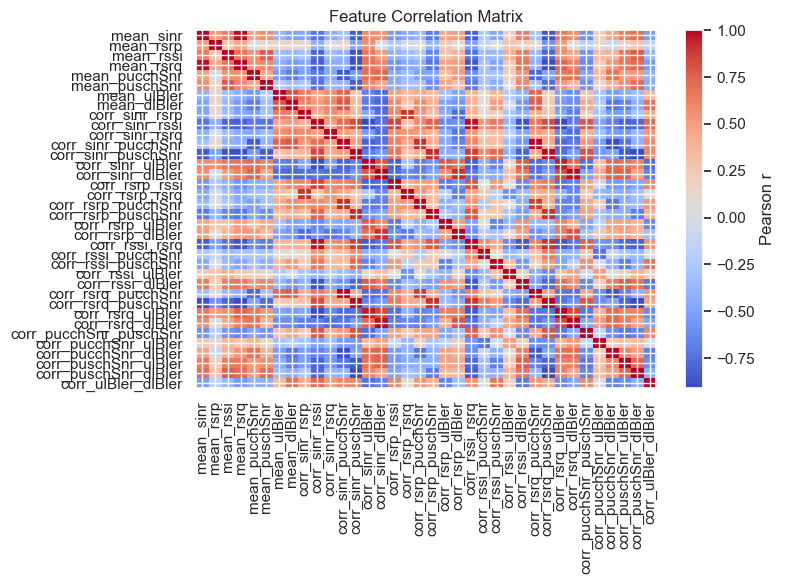

In [19]:

numeric_cols = sig_df.select_dtypes(include=[np.number]).columns.tolist()
corr = sig_df[numeric_cols].corr()
scaler = StandardScaler()
df_c = pd.DataFrame()
df_c[numeric_cols] = scaler.fit_transform(sig_df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [20]:
constant_cols = [col for col in numeric_cols if sig_df[col].nunique() <= 1]
print("Constant columns:", constant_cols)

Constant columns: []


In [21]:
# Get average absolute correlation of each feature with others
mean_corr = corr.abs().mean().sort_values()

print("Features with lowest mean correlation:")
print(mean_corr)


Features with lowest mean correlation:
mean_rsrp                 0.252786
corr_rssi_ulBler          0.316989
corr_rssi_pucchSnr        0.321606
corr_pucchSnr_ulBler      0.349358
corr_rsrp_rsrq            0.410747
corr_rssi_puschSnr        0.420821
mean_ulBler               0.451968
corr_rsrp_ulBler          0.464200
corr_sinr_rsrp            0.467332
corr_rsrp_pucchSnr        0.481716
mean_puschSnr             0.482456
corr_sinr_rsrq            0.490901
corr_ulBler_dlBler        0.500068
corr_rsrp_dlBler          0.500597
corr_rsrp_puschSnr        0.508902
mean_dlBler               0.520273
corr_pucchSnr_puschSnr    0.521188
mean_rssi                 0.522177
mean_pucchSnr             0.532027
corr_pucchSnr_dlBler      0.546453
corr_puschSnr_dlBler      0.547184
corr_rsrp_rssi            0.552063
mean_sinr                 0.560482
corr_rsrq_pucchSnr        0.563660
corr_rssi_dlBler          0.584048
corr_sinr_pucchSnr        0.590368
mean_rsrq                 0.597234
corr_puschSnr_ul

In [22]:
low_corr_pairs = []
for col in corr.columns:
    for row in corr.index:
        if col != row and abs(corr.loc[row, col]) < 0.05:
            low_corr_pairs.append((row, col, corr.loc[row, col]))

# View top 10 uncorrelated pairs
print("Low-correlation feature pairs:")
for a, b, val in low_corr_pairs[:10]:
    print(f"{a} vs {b}: r = {val:.2f}")


Low-correlation feature pairs:
mean_pucchSnr vs mean_rsrp: r = -0.02
corr_sinr_rsrq vs mean_rsrp: r = -0.00
corr_sinr_dlBler vs mean_rsrp: r = -0.02
corr_rsrp_rsrq vs mean_rsrp: r = -0.03
corr_rsrp_pucchSnr vs mean_rsrp: r = 0.03
corr_rssi_puschSnr vs mean_rsrp: r = -0.00
mean_rsrp vs mean_pucchSnr: r = -0.02
mean_rsrp vs corr_sinr_rsrq: r = -0.00
mean_rsrp vs corr_sinr_dlBler: r = -0.02
corr_rssi_pucchSnr vs corr_rsrp_rssi: r = 0.04


In [23]:
sig_df.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp',
       'corr_sinr_rssi', 'corr_sinr_rsrq', 'corr_sinr_pucchSnr',
       'corr_sinr_puschSnr', 'corr_sinr_ulBler', 'corr_sinr_dlBler',
       'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler',
       'corr_rssi_rsrq', 'corr_rssi_pucchSnr', 'corr_rssi_puschSnr',
       'corr_rssi_ulBler', 'corr_rssi_dlBler', 'corr_rsrq_pucchSnr',
       'corr_rsrq_puschSnr', 'corr_rsrq_ulBler', 'corr_rsrq_dlBler',
       'corr_pucchSnr_puschSnr', 'corr_pucchSnr_ulBler',
       'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler', 'corr_puschSnr_dlBler',
       'corr_ulBler_dlBler'],
      dtype='object')

In [24]:
sig_df.drop(columns = ['mean_rsrp', 'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler',], inplace = True)

In [25]:
sig_df.columns

Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler'],
      dtype='object')

In [26]:
sig_df['rnti_true'] = window_rntis

In [27]:
n_total = len(sig_df)

# number of windows with any NaN
n_with_nan = sig_df.isna().any(axis=1).sum()

print(f"{n_with_nan} out of {n_total} windows ({n_with_nan/n_total:.1%}) have at least one NaN")

1330 out of 1671 windows (79.6%) have at least one NaN


In [28]:
nan_per_col = sig_df.isna().sum().sort_values(ascending=False)
print(nan_per_col)

corr_sinr_ulBler          1260
corr_sinr_rsrq            1251
corr_rsrq_ulBler          1242
corr_sinr_dlBler          1204
corr_sinr_rsrp            1190
corr_rsrq_dlBler          1184
corr_sinr_pucchSnr        1183
corr_sinr_puschSnr        1183
corr_sinr_rssi            1183
corr_rsrq_pucchSnr        1167
corr_rssi_rsrq            1167
corr_rsrq_puschSnr        1167
corr_ulBler_dlBler         308
corr_pucchSnr_dlBler       214
corr_puschSnr_dlBler       214
corr_rssi_dlBler           214
corr_pucchSnr_ulBler       121
corr_puschSnr_ulBler       121
corr_rssi_ulBler           121
corr_pucchSnr_puschSnr       0
mean_sinr                    0
corr_rssi_pucchSnr           0
corr_rssi_puschSnr           0
mean_rssi                    0
mean_dlBler                  0
mean_ulBler                  0
mean_puschSnr                0
mean_pucchSnr                0
mean_rsrq                    0
rnti_true                    0
dtype: int64


In [29]:
sig_df.dropna(inplace = True)

In [30]:
#sig_df = sig_df.fillna(0)
sig_df

,mean_sinr,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler,corr_sinr_rsrp,corr_sinr_rssi,corr_sinr_rsrq,...,corr_rsrq_puschSnr,corr_rsrq_ulBler,corr_rsrq_dlBler,corr_pucchSnr_puschSnr,corr_pucchSnr_ulBler,corr_pucchSnr_dlBler,corr_puschSnr_ulBler,corr_puschSnr_dlBler,corr_ulBler_dlBler,rnti_true
7,-0.768884,1.152624,0.137630,1.136028,0.173630,-0.720538,-0.403093,0.998423,-0.482442,0.998749,...,-0.152363,0.015225,0.039958,0.345716,0.661558,0.739841,0.043533,0.201510,0.382870,8f53
56,0.285840,0.282002,0.254218,0.432575,-0.080773,-0.646249,-0.302555,-0.948818,0.268611,1.000000,...,-0.103851,-0.280960,-0.502917,0.504655,-0.570370,-0.450082,-0.458872,-0.403286,0.888984,6bbd
75,0.239873,-2.018226,0.109965,-1.661884,-1.522609,1.443549,2.150353,0.976832,0.874972,1.000000,...,0.923882,-0.410210,-0.995819,0.927060,-0.402519,-0.994827,-0.374588,-0.920568,0.396271,2f28
76,0.244911,-1.904772,0.125773,-1.232659,-1.337589,1.456568,1.927449,0.984861,0.844478,1.000000,...,0.909741,-0.314306,-0.999592,0.904058,-0.312049,-0.998031,-0.406835,-0.909270,0.314170,1c79
77,0.245541,-2.019226,0.127750,-1.872523,-1.629657,1.431412,2.177078,0.217093,0.111242,1.000000,...,0.262842,-0.296713,-0.879882,0.503829,-0.397112,-0.878831,-0.028389,-0.460059,0.463879,1c79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1666,0.002482,0.950151,0.200864,1.765955,0.733316,0.818647,1.361307,0.369592,-0.239413,0.947564,...,-0.152353,-0.152560,-0.199277,0.173613,0.479149,0.731870,0.201584,0.214625,0.828904,2e6c
1667,-0.503786,0.380881,0.064515,2.123643,0.349399,1.261352,1.724905,0.334375,-0.321937,0.868116,...,-0.198013,0.223785,0.531990,0.437563,0.260377,0.597524,-0.049669,-0.058210,0.630562,2e6c
1668,-0.693951,0.658657,0.028946,2.147489,0.686400,1.387654,2.021417,0.218051,-0.285447,0.903384,...,-0.167274,-0.033483,0.359134,0.242354,0.051021,0.722883,-0.013939,0.060903,0.508174,98f2
1669,-0.726065,-0.723937,0.017089,1.980568,-0.351035,1.291371,2.064360,-0.111993,0.326705,0.912711,...,0.074987,-0.136297,-0.219837,-0.258017,-0.080679,0.169529,-0.266935,-0.272815,0.836387,719e


In [31]:
#nan_frac = sig_df.isna().mean()

# 2. Choose a threshold (e.g. 0.5 for 50%)
#threshold = 0.5

# 3. Identify columns to drop vs keep
#drop_cols = nan_frac[nan_frac > threshold].index.tolist()
#keep_cols = nan_frac[n0.an_frac <= threshold].index.tolist()

#print(f"Dropping {len(drop_cols)} columns with >{threshold*100:.0f}% NaNs:")
#print(drop_cols)
#print(f"\nKeeping {len(keep_cols)} columns with ≤{threshold*100:.0f}% NaNs:")
#print(keep_cols)

In [32]:
#sig_df.drop(columns= drop_cols, inplace = True)

In [33]:
#sig_df.dropna(inplace = True)

In [34]:
sig_df.columns

Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler', 'rnti_true'],
      dtype='object')

APPLY K-Means CLustering on whole data to determine the number of clusters

In [35]:
feature_cols = [col for col in sig_df.columns 
                if col.startswith('mean_') or col.startswith('corr_')]
X = sig_df[feature_cols].values
best_k, best_score = 2, -1
for k in range(2, 30):
    km = KMeans(n_clusters=k, random_state=0, init='k-means++').fit(X)
    score = silhouette_score(X, km.labels_)
    print(score)
    if score > best_score:
        best_k, best_score = k, score

print(f"Optimal K ≈ {best_k} (silhouette={best_score:.3f})")
best_k = best_k
# 2. Fit final k-means
km_final = KMeans(n_clusters=best_k, random_state=0, init='k-means++').fit(X)
labels   = km_final.labels_
centroids= km_final.cluster_centers_

# 3. Attach back to your sig_df
sig_df['kmeans_label'] = labels

C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

0.6473665563311882
0.6054527814291184
0.5341691390130404
0.5546748606671721
0.587413394629602
0.5564152112643568
0.5672156561717474
0.2639140850515927
0.2763060677869771
0.28369416915009427
0.25054021079862543
0.24391684116555973
0.24705706016820814
0.24316879063942728
0.2475244135369791
0.24894360806611968
0.2500615135341199
0.2501259209605109
0.24778608071502664
0.2406867818784871
0.2378438498962172
0.23775918640135293
0.24228882437663196
0.2429535029302978
0.21621098668129995
0.21652738620001924
0.2208462934705325
0.21955947157891129
Optimal K ≈ 2 (silhouette=0.647)


C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\madda\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [36]:
km_final.cluster_centers_.shape

(2, 29)

PCA PROJECTION TO VISUALISE THE CLUSTERS ON 2 PRINCIPLE COMPONENTS

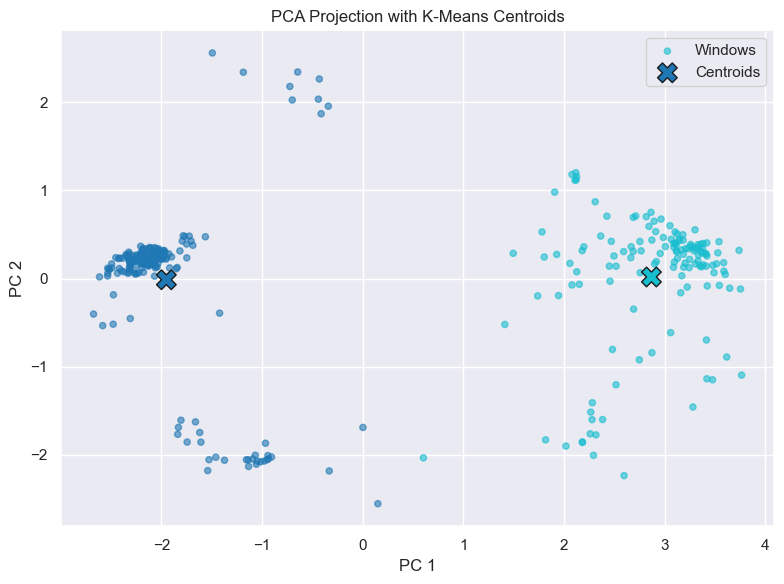

In [37]:
labels = sig_df['kmeans_label'].values        # or 'dbscan_label'

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Project centroids into the same PCA space
centroids = km_final.cluster_centers_               # shape (K, n_features)
centroids_pca = pca.transform(centroids)      # shape (K, 2)

# 3. Scatter plot of windows
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels,
    cmap='tab10',
    s=20,
    alpha=0.6,
    label="Windows"
)

# 4. Overlay centroids
plt.scatter(
    centroids_pca[:,0], centroids_pca[:,1],
    c=range(len(centroids_pca)),
    cmap='tab10',
    marker='X',
    s=200,
    edgecolor='k',
    label="Centroids"
)

plt.legend(loc='best')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection with K-Means Centroids")
plt.tight_layout()
plt.show()


TSNE : NON LINEAR PROJECTION ON 2 COMPOENTNS

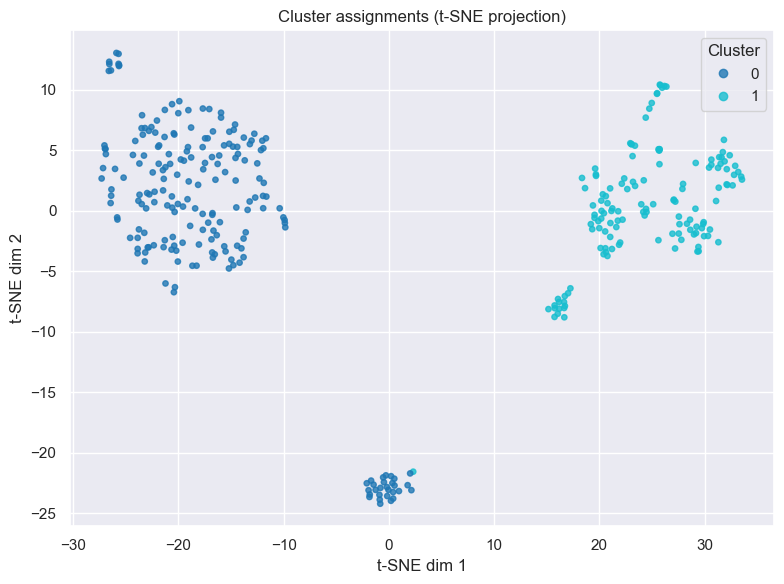

In [38]:
from sklearn.manifold import TSNE

# 1. Embed in 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

# 2. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=labels,
    cmap='tab10',
    s=15,
    alpha=0.8
)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("Cluster assignments (t-SNE projection)")
plt.tight_layout()
plt.show()

TESTING ON NEW DATA(AUTHENTIC AND NON-AUTHENTIC): READ the DATA FILES THAT You want to test on

In [39]:
#preprocessing test data

In [61]:
#authentic_1_noise_less_antennas.csv
#authentic_2_normal.csv
#authentic_3_obstacles.csv
#non_authentic_1_diff_position.csv
#non_authentic_2_less_antennas_diff_position.csv
#non_authentic_3_no_antennas.csv

In [90]:
df1 = pd.read_csv('non_authentic_3_no_antennas.csv', sep=',', low_memory=False) # read the testing data files

In [91]:
df1.columns

Index(['ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', '_id.$oid', 'avgLdpcIterations', 'rnti', 'ulBytes',
       'pmi', 'rsrp', 'cqi', 'pucchSnr', 'rssi', 'ueId', 'inSync', 'dlBytes',
       'dlMcs', 'ulMcs', 'ulBler', 'ri', 'pcmax', 'puschSnr', 'dlBler', 'phr',
       'rsrq', 'sinr'],
      dtype='object')

In [92]:
#drop the Nan values and remove outliers using Isolation Forest

In [93]:
df1.dropna(inplace = True)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df1['iforest_label'] = iso.fit_predict(df1[numeric_cols])
# label = −1 is an outlier
n_iso = (df1['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df1):.2%})")
df1 = df1[df1['iforest_label'] == 1].reset_index(drop=True)
df1.drop(columns=['iforest_label'], inplace=True)

IsolationForest outliers: 167 (1.00%)


In [94]:
#Keep the features same as training data

to_drop = [
    '_id', 'id', 'ueId',  'cqi', '_id.$oid', 'avgLdpcIterations', 'pmi',  # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df1 = df1.drop(columns=to_drop, errors='ignore')

print(df1.columns)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler() # Normalise using StandardSCALER
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])
print(df1.head())

Index(['rnti', 'rsrp', 'pucchSnr', 'rssi', 'ulBler', 'puschSnr', 'dlBler',
       'rsrq', 'sinr'],
      dtype='object')
   rnti      rsrp  pucchSnr      rssi    ulBler  puschSnr    dlBler      rsrq  \
0  30be  1.382723  0.376472  0.205716 -1.043344  0.356751  0.048947  0.563005   
1  23b3  0.730811  0.139544 -0.076750  1.087956  0.231272 -0.444511  0.563005   
2  308f -1.343455  1.798043 -2.936717  1.087956 -1.588159  2.597808 -1.924997   
3  6695 -0.158160  0.376472  0.505836  0.983630  0.105794  0.007137  0.563005   
4  7acd -1.402719 -2.703598 -2.936717  1.087956 -1.839115  2.597808 -2.256730   

       sinr  
0  0.646472  
1  0.558259  
2 -1.558851  
3  0.073088  
4 -1.647064  


In [95]:
#prepare the time windowed sequences for test data

In [96]:
sig_df_test, window_rntis_test = extract_phy_signatures(
    df1,
    window_size=100,
    step_size=100,
    label_col='rnti'
)


In [97]:
sig_df_test.dropna(inplace = True)

In [98]:

sig_df_test.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp',
       'corr_sinr_rssi', 'corr_sinr_rsrq', 'corr_sinr_pucchSnr',
       'corr_sinr_puschSnr', 'corr_sinr_ulBler', 'corr_sinr_dlBler',
       'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler',
       'corr_rssi_rsrq', 'corr_rssi_pucchSnr', 'corr_rssi_puschSnr',
       'corr_rssi_ulBler', 'corr_rssi_dlBler', 'corr_rsrq_pucchSnr',
       'corr_rsrq_puschSnr', 'corr_rsrq_ulBler', 'corr_rsrq_dlBler',
       'corr_pucchSnr_puschSnr', 'corr_pucchSnr_ulBler',
       'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler', 'corr_puschSnr_dlBler',
       'corr_ulBler_dlBler'],
      dtype='object')

In [99]:
sig_df_test.drop(columns = ['mean_rsrp', 'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler'], inplace = True)

In [100]:
sig_df_test.columns

Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler'],
      dtype='object')

In [101]:
import numpy as np
from scipy.spatial.distance import mahalanobis
from numpy.linalg import inv
from collections import defaultdict

# 1. Get X and X_new using consistent features
X = sig_df[feature_cols].values
X_new = sig_df_test[feature_cols].values
labels = sig_df['kmeans_label'].values  # Cluster labels from KMeans
centroids = km_final.cluster_centers_

# 2. Compute per-cluster covariance and inverse
cluster_invs = {}
for k in np.unique(labels):
    X_k = X[labels == k]
    cov_k = np.cov(X_k, rowvar=False)
    cov_k += 1e-6 * np.eye(cov_k.shape[0])  # Stabilize
    cluster_invs[k] = inv(cov_k)

# 3. Compute Mahalanobis distances for training samples
train_mahal_dists = []
for i, x in enumerate(X):
    k = labels[i]
    d = mahalanobis(x, centroids[k], cluster_invs[k])
    train_mahal_dists.append((k, d))

# 4. Compute 95th percentile distance per cluster (thresholds)
mahal_thresh = defaultdict(list)
for k, d in train_mahal_dists:
    mahal_thresh[k].append(d)

cluster_thresholds = {
    k: np.percentile(mahal_thresh[k], 95)
    for k in mahal_thresh
}


In [102]:
print(sig_df_test.shape)

(165, 29)


In [103]:
# 5. Predict labels for new test data
new_labels = km_final.predict(X_new)

# 6. Compute Mahalanobis distance for each test sample
mahal_dists = []
for i, x in enumerate(X_new):
    k = new_labels[i]
    d = mahalanobis(x, centroids[k], cluster_invs[k])
    mahal_dists.append(d)

sig_df_test['mahal_dist'] = mahal_dists
sig_df_test['assigned_cluster'] = new_labels

# 7. Classify as authentic vs non-authentic
sig_df_test['authenticity'] = [
    'authentic' if mahal_dists[i] <= cluster_thresholds[new_labels[i]] else 'non_authentic'
    for i in range(len(X_new))
]

In [104]:
#Evaluate the performance

In [105]:
km_final.cluster_centers_.shape

(2, 29)

In [106]:
sig_df.columns


Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler', 'rnti_true',
       'kmeans_label'],
      dtype='object')

In [107]:
sig_df.columns

Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler', 'rnti_true',
       'kmeans_label'],
      dtype='object')

In [108]:
sig_df_test.columns

Index(['mean_sinr', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp', 'corr_sinr_rssi',
       'corr_sinr_rsrq', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_rssi_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rsrq_pucchSnr', 'corr_rsrq_puschSnr',
       'corr_rsrq_ulBler', 'corr_rsrq_dlBler', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler',
       'corr_puschSnr_dlBler', 'corr_ulBler_dlBler', 'mahal_dist',
       'assigned_cluster', 'authenticity'],
      dtype='object')

In [109]:
from sklearn.metrics import pairwise_distances

X = sig_df[sig_df.columns].drop(columns = [ 'rnti_true',
       'kmeans_label']).values
X_new = sig_df_test[sig_df_test.columns].drop(columns = ['mahal_dist',
       'assigned_cluster', 'authenticity']).values
print(X.shape)
print(X_new.shape)
# Train labels and assigned cluster distances
print(km_final.cluster_centers_.shape)
train_labels = km_final.labels_
train_dists = pairwise_distances(X, km_final.cluster_centers_)
train_assigned_dists = np.array([
    train_dists[i, label] for i, label in enumerate(train_labels)
])

# Per-cluster threshold
cluster_thresholds = {}
for k in range(km_final.n_clusters):
    dists_k = train_assigned_dists[train_labels == k]
    cluster_thresholds[k] = np.percentile(dists_k, 80)

# Predict on new data
new_labels = km_final.predict(X_new)
test_dists = pairwise_distances(X_new, km_final.cluster_centers_)

# Distances to assigned centroid
sig_df_test['new_dists'] = np.array([
    test_dists[i, new_labels[i]] for i in range(len(new_labels))
])

# Label based on distance to assigned cluster centroid
sig_df_test['authenticity'] = [
    'authentic' if sig_df_test['new_dists'].iloc[i] <= cluster_thresholds[new_labels[i]] else 'non_authentic'
    for i in range(len(new_labels))
]

(341, 29)
(165, 29)
(2, 29)


In [110]:
cluster_thresholds

{0: 0.9796061926029523, 1: 2.364588588101109}

In [111]:
sig_df_test

,mean_sinr,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler,corr_sinr_rsrp,corr_sinr_rssi,corr_sinr_rsrq,...,corr_pucchSnr_puschSnr,corr_pucchSnr_ulBler,corr_pucchSnr_dlBler,corr_puschSnr_ulBler,corr_puschSnr_dlBler,corr_ulBler_dlBler,mahal_dist,assigned_cluster,authenticity,new_dists
0,-0.429285,-0.994411,-0.498542,-0.403023,-0.416822,0.636989,0.871147,0.957839,0.853260,0.977597,...,0.385691,-0.295535,-0.624577,-0.297454,-0.702170,0.435700,24.930018,0,non_authentic,2.226323
1,-0.451338,-1.070147,-0.500201,-0.457516,-0.423095,0.638611,0.828966,0.959800,0.872225,0.978144,...,0.477892,-0.333949,-0.687088,-0.179162,-0.745777,0.424020,27.125048,0,non_authentic,2.208608
2,-0.459718,-1.113929,-0.515129,-0.350898,-0.404901,0.642926,0.880953,0.961918,0.905427,0.976980,...,0.470149,-0.332627,-0.639730,-0.379799,-0.667998,0.405100,27.321851,0,non_authentic,2.179051
3,-0.498973,-1.019303,-0.566548,-0.578350,-0.471404,0.620870,0.841843,0.961538,0.840849,0.983495,...,0.501688,-0.323354,-0.749286,-0.197423,-0.706349,0.478785,23.145085,0,non_authentic,2.079227
4,-0.495885,-1.024423,-0.546644,-0.727615,-0.410548,0.596604,0.811211,0.958476,0.803030,0.981432,...,0.590964,-0.340656,-0.835328,-0.356595,-0.658608,0.486163,22.548132,0,non_authentic,2.066466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.175856,0.367605,0.189805,0.499675,0.344830,-0.348399,-0.397115,0.946765,-0.579010,0.951698,...,0.110695,-0.574395,0.318401,-0.141315,0.025539,-0.350348,10.656283,1,authentic,1.901834
161,0.183795,0.445283,0.198098,0.513891,0.109559,-0.338930,-0.441573,0.944763,-0.587494,0.952933,...,-0.158833,-0.676048,0.269209,0.242696,-0.065365,-0.307128,10.262522,1,authentic,1.872470
162,0.178502,0.342006,0.208050,0.530476,0.259505,-0.355412,-0.476202,0.949029,-0.632202,0.950317,...,0.147234,-0.605118,0.221779,-0.145587,0.000424,-0.290402,9.513998,1,authentic,1.805592
163,0.160419,0.444577,0.201416,0.497306,0.028625,-0.347592,-0.431488,0.953412,-0.644103,0.948533,...,-0.111360,-0.510706,0.223334,0.246260,-0.047345,-0.265335,9.322639,1,authentic,1.702966


In [112]:
print(sig_df_test['authenticity'].value_counts())

authenticity
authentic        100
non_authentic     65
Name: count, dtype: int64


In [113]:
explained_var = pca.explained_variance_ratio_
total_var = explained_var.sum()
print(total_var)

0.8120248886331434


In [114]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # X from your training data
centroids_pca = pca.transform(km_final.cluster_centers_)

In [115]:
X_new_pca = pca.transform(X_new)

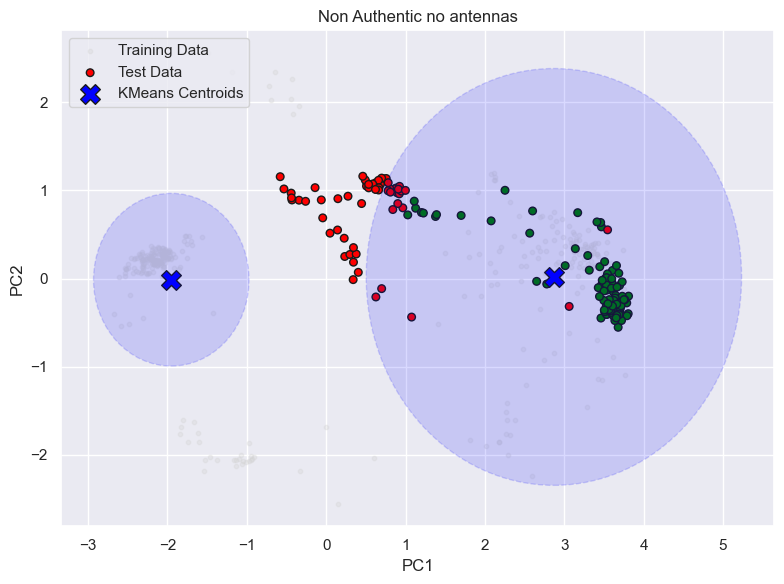

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot training data (light gray background)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.3, label='Training Data')

# Plot new test data points
color_map = {'authentic': 'green', 'non_authentic': 'red'}
colors = sig_df_test['authenticity'].map(color_map)

plt.scatter(X_new_pca[:, 0], X_new_pca[:, 1], c=colors, s=30, edgecolor='k', label='Test Data')

# Overlay centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='blue', marker='X', s=200, edgecolor='k', label='KMeans Centroids'
)
for i, (cx, cy) in enumerate(centroids_pca):
    # Use per-cluster threshold if available; otherwise fallback to global
    radius = cluster_thresholds.get(i)
    
    # Optional: transform the threshold radius into PCA space — approximate by applying PCA to vector with that magnitude
    #unit_vec = km_final.cluster_centers_[i] + radius * np.ones(km_final.cluster_centers_.shape[1])
    #transformed_vec = pca.transform([unit_vec])[0]
    #scaled_radius = ((transformed_vec - centroids_pca[i])**2).sum()**0.5

    circle = Circle((cx, cy), radius, color='blue', alpha=0.15, linestyle='--', linewidth=1, fill=True)
    plt.gca().add_patch(circle)

plt.title('Non Authentic no antennas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='mahal_dist', ylabel='Count'>

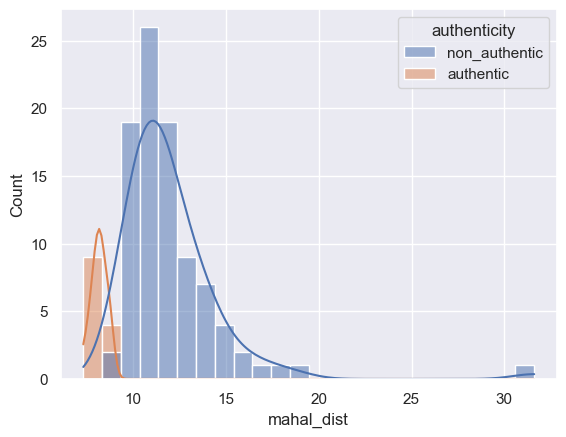

In [78]:
sns.histplot(data=sig_df_test, x='mahal_dist', hue='authenticity', kde=True)

In [79]:
print(sig_df_test['authenticity'].value_counts())

authenticity
non_authentic    92
authentic        13
Name: count, dtype: int64


In [80]:
for k, t in cluster_thresholds.items():
    print(f"Cluster {k}: threshold = {t:.2f}")

Cluster 1: threshold = 9.03
Cluster 0: threshold = 10.58


In [36]:
import pandas as pd
from pathlib import Path
#authentic_1_noise_less_antennas.csv
#authentic_2_normal.csv
#authentic_3_obstacles.csv
#non_authentic_1_diff_position.csv
#non_authentic_2_less_antennas_diff_position.csv
#non_authentic_3_no_antennas.csv
# Define files and their labels
authentic_files = ['authentic_1_noise_less_antennas.csv', 'authentic_2_normal.csv', 'authentic_3_obstacles.csv']
non_authentic_files = ['non_authentic_1_diff_position.csv', 'non_authentic_2_less_antennas_diff_position.csv', 'non_authentic_3_no_antennas.csv']

all_sigs = []
all_labels = []
raw_cols = list(scaler.feature_names_in_)  # DO NOT use for scaler here
raw_cols = ['sinr', 'rsrp', 'rssi', 'rsrq', 'pucchSnr', 'puschSnr', 'ulBler', 'dlBler']

for file in authentic_files:
    df = pd.read_csv(file)
    df['label'] = 'authentic'  # File-level label for all rows
    # Safe scaling using feature_names_in_ from the trained scaler
    df_scaled = pd.DataFrame(
        scaler.transform(df[raw_cols]),
        columns=raw_cols
    )
    print(df_scaled.columns)

    df_scaled['label'] = df['label']
    sigs, labels = extract_phy_signatures(
        df_scaled,
        raw_features=raw_cols,
        window_size=100,
        step_size=100,
        label_col='label'
    )
    all_sigs.append(sigs)
    all_labels += labels

for file in non_authentic_files:
    df = pd.read_csv(file)
    df['label'] = 'non_authentic'
    # Safe scaling using feature_names_in_ from the trained scaler
    df_scaled = pd.DataFrame(
        scaler.transform(df[raw_cols]),
        columns=raw_cols
    )

    df_scaled['label'] = df['label']
    sigs, labels = extract_phy_signatures(
        df_scaled,
        raw_features=raw_cols,
        window_size=100,
        step_size=100,
        label_col='label'
    )
    all_sigs.append(sigs)
    all_labels += labels

# Combine all signature windows
sig_df_test = pd.concat(all_sigs, ignore_index=True)
sig_df_test['true_authenticity'] = all_labels

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- dlBler
- pucchSnr
- puschSnr
- rsrp
- rsrq
- ...
Feature names seen at fit time, yet now missing:
- corr_pucchSnr_dlBler
- corr_pucchSnr_puschSnr
- corr_pucchSnr_ulBler
- corr_puschSnr_dlBler
- corr_puschSnr_ulBler
- ...


In [98]:
sig_df_test.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_pucchSnr', 'mean_puschSnr',
       'mean_ulBler', 'mean_dlBler', 'mean_rsrq', 'corr_sinr_rsrp',
       'corr_sinr_rssi', 'corr_sinr_pucchSnr', 'corr_sinr_puschSnr',
       'corr_sinr_ulBler', 'corr_sinr_dlBler', 'corr_sinr_rsrq',
       'corr_rsrp_rssi', 'corr_rsrp_pucchSnr', 'corr_rsrp_puschSnr',
       'corr_rsrp_ulBler', 'corr_rsrp_dlBler', 'corr_rsrp_rsrq',
       'corr_rssi_pucchSnr', 'corr_rssi_puschSnr', 'corr_rssi_ulBler',
       'corr_rssi_dlBler', 'corr_rssi_rsrq', 'corr_pucchSnr_puschSnr',
       'corr_pucchSnr_ulBler', 'corr_pucchSnr_dlBler', 'corr_pucchSnr_rsrq',
       'corr_puschSnr_ulBler', 'corr_puschSnr_dlBler', 'corr_puschSnr_rsrq',
       'corr_ulBler_dlBler', 'corr_ulBler_rsrq', 'corr_dlBler_rsrq',
       'true_authenticity'],
      dtype='object')

In [99]:
sig_df.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler', 'corr_sinr_rsrp',
       'corr_sinr_rssi', 'corr_sinr_rsrq', 'corr_sinr_pucchSnr',
       'corr_sinr_puschSnr', 'corr_sinr_ulBler', 'corr_sinr_dlBler',
       'corr_rsrp_rssi', 'corr_rsrp_rsrq', 'corr_rsrp_pucchSnr',
       'corr_rsrp_puschSnr', 'corr_rsrp_ulBler', 'corr_rsrp_dlBler',
       'corr_rssi_rsrq', 'corr_rssi_pucchSnr', 'corr_rssi_puschSnr',
       'corr_rssi_ulBler', 'corr_rssi_dlBler', 'corr_rsrq_pucchSnr',
       'corr_rsrq_puschSnr', 'corr_rsrq_ulBler', 'corr_rsrq_dlBler',
       'corr_pucchSnr_puschSnr', 'corr_pucchSnr_ulBler',
       'corr_pucchSnr_dlBler', 'corr_puschSnr_ulBler', 'corr_puschSnr_dlBler',
       'corr_ulBler_dlBler', 'rnti_true', 'kmeans_label'],
      dtype='object')